In [2]:
#import required libs
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
%matplotlib inline

### Image Pre-processing

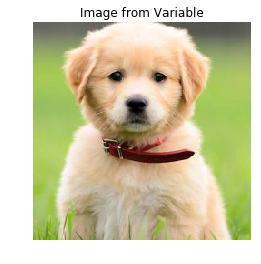

In [3]:
# Loads image from filename, 
# Resizes it to indicated size 
# Normalizes the image as vgg19 was trained on normalized images
# Converts it into a Variable whose gradient can be taken
# Also adds a fake batch dimension to image, making it ready to be inputted into vgg19
def load_image(filename, size):
    image = Image.open(filename)
    loader = transforms.Compose([
        transforms.Resize((240,240)),  
        transforms.ToTensor()
    ])
    
    image_tensor = loader(image).unsqueeze(0)
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_normalized = (image_tensor - mean) / std
    
    image_variable = Variable(image_tensor_normalized, requires_grad=True)
    assert(image_variable.size() == torch.Size([1, 3, 240, 240]))
    
    return image_variable


# Grab image, need it to be 240x240
image_var = load_image("./dog.jpg", (240,240))


# Displays the image from its tensor (think modified image tensor, after adding epsilon noise)
def show_image(tensor, title=None):
    image = tensor.clone()        # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_unnormalized = (image * std) + mean
    
    unloader = transforms.ToPILImage()
    image_final = unloader(image_tensor_unnormalized)
    
    plt.figure()
    plt.axis('off')
    plt.imshow(image_final)
    
    if title is not None:
        plt.title(title)
        
    return


show_image(image_var.data, title='Image from Variable')

### Model: VGG19 (State-of-the-art, pre-trained)
Needs images resized to 240x240

In [4]:
cnn = models.vgg19(pretrained=True).eval()

### Classifying image and showing top 10 classes

In [5]:
# Let's try classifying the image
image_trial = load_image("./dog.jpg", (240,240))
output = cnn(image_trial)

# Prints the top k classes with the confidence levels from the out=model(image) variable
def top_k(out, k=10):
    # Get most probable class
    label_idx = torch.max(out.data, 1)[1][0]

    # Have an output tensor of classes and values per class
    # Need a mapping from class indices to class names
    with open('imagenet_class_index.json') as f: class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

    # Get top 10 labels
    labels = [idx2label[idx] for idx in out[0].sort()[1][-k:]]
    labels.reverse()

    # Also need to pass the tensor to softmax for probability dist on classes for confidence level
    confidences = F.softmax(out, dim=1)

    # Get top 10 confidences
    confidences = list(np.asarray(confidences.data.sort()[0][0]))
    confidences.reverse()

    for i in range(k):
        print(labels[i], confidences[i]*100, '%')
        
    return

top_k(output)

golden_retriever 96.53496146202087 %
Labrador_retriever 2.170245535671711 %
tennis_ball 0.3255081130191684 %
kuvasz 0.1784397754818201 %
soccer_ball 0.17493321793153882 %
Great_Pyrenees 0.11685092467814684 %
clumber 0.10115603217855096 %
Border_collie 0.06372759817168117 %
Sussex_spaniel 0.056562724057585 %
Brittany_spaniel 0.04760420706588775 %


### Add perturbations to get another class with 99% accuracy
We use FGSM, find perturbations which increase the loss for the true class subsequently leading to misclassification. Also, FGSM is a non-targeted method. We can easily convert it into targeted method by maximizing probability $P(Y_{target}|X)$ for some target class $Y_{target}$ and input image $X$. 

For a neural network with cross-entropy loss $J(X,Y)$, the formula will be:
$$X_{adversarial}=X_{input}− \epsilon \cdot \text{sign}(\nabla_X J(X, Y_{target})$$
 
Instead of adding perturbation to the original input, we need to remove it from the original input. 

We build this mechanism such that we can target any desired class. We need to iterate a number of times to max out the confidence level on the target class. 

In [101]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # k pixels thick border
    k=1
    grad[:, :, k:-k, k:-k] = 0
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


golden_retriever 44.67116594314575 %
red_wine 4.326852411031723 %
Brittany_spaniel 3.9988305419683456 %
Border_collie 3.026624582707882 %
clumber 2.806769870221615 %
soccer_ball 2.6008332148194313 %
kuvasz 2.4471336975693703 %
sunglasses 2.106505259871483 %
Labrador_retriever 2.078148163855076 %
tennis_ball 1.8782319501042366 %


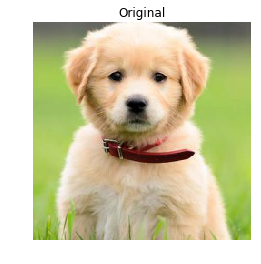

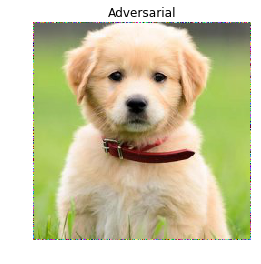

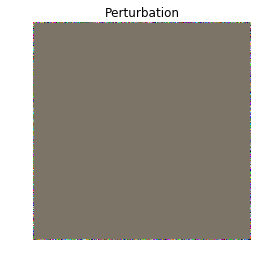

In [102]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title='Adversarial')
show_image(image_start.data - image_tensor, title='Perturbation')

In [7]:
def image_plus_perturbation(image_name, perturbation, draw=True):
    image = load_image(image_name, (240,240))
    print('Original:')
    top_k(cnn(image), 1)
    
    image_w_perturbation = image + perturbation
    print('After Perturbation:')
    top_k(cnn(image_w_perturbation), 1)    
    
    if draw:
        show_image(image, title='Original')
        show_image(image_w_perturbation, title='With Perturbation')
    return

perturbation = image_start.data - image_tensor
image_plus_perturbation("./bird.jpg", perturbation)

NameError: name 'image_start' is not defined

In [11]:
image_plus_perturbation("./dancing.jpg", perturbation_wine)

NameError: name 'perturbation_wine' is not defined

### Let's sample 5 random classes, Corrupt the dog to each class to get perturbations P_1,...,P_10 and see if they all work

In [13]:
# Modularize Pipeline from above to get pertuebation for dog to target_class which is the index of the target class
def get_perturbation(target_class):
    y_target = Variable(torch.LongTensor([target_class]), requires_grad=False)

    # Max change per pixel
    epsilon = 1000
    # Max iterations
    num_steps = 100
    # Step size
    alpha = 0.25
    # Loss Fn
    loss = torch.nn.CrossEntropyLoss()
    # Starting image 
    image_start = load_image("./dog.jpg", (240,240))

    # This tensor stays fixed for reference point
    image_tensor = image_start.data

    for i in range(num_steps):
        # Fresh gradients
        zero_gradients(image_start)

        # Get CNN clasiffication and loss
        output = cnn.forward(image_start)
        loss_value = loss(output, y_target)

        # Backward call to get gradients
        loss_value.backward()

        # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
        grad = alpha * torch.sign(image_start.grad.data)

        # k pixels thick border
        k=10
        grad[:, :, k:-k, k:-k] = 0

        image_temp = image_start.data - grad
        total_grad = image_temp - image_tensor
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        image_adversarial = image_tensor + total_grad
        image_start.data = image_adversarial
        
    print('Got Perturbation')
    return image_start.data - image_tensor

In [152]:
p_1 = get_perturbation(46) #Green_lizard
p_2 = get_perturbation(344) #Hippopotamus
p_3 = get_perturbation(603) #Horse_cart
p_4 = get_perturbation(776) #Sax
p_5 = get_perturbation(924) #Guac

Got Perturbation
Got Perturbation
Got Perturbation
Got Perturbation


In [12]:
print("Bird + Perturbation")
image_plus_perturbation("./bird.jpg", p_1, False)
image_plus_perturbation("./bird.jpg", p_2, False)
image_plus_perturbation("./bird.jpg", p_3, False)
image_plus_perturbation("./bird.jpg", p_4, False)
image_plus_perturbation("./bird.jpg", p_5, False)
print("\n", "Dance + Perturbation")
image_plus_perturbation("./dancing.jpg", p_1, False)
image_plus_perturbation("./dancing.jpg", p_2, False)
image_plus_perturbation("./dancing.jpg", p_3, False)
image_plus_perturbation("./dancing.jpg", p_4, False)
image_plus_perturbation("./dancing.jpg", p_5, False)
print("\n", "Bike + Perturbation")
image_plus_perturbation("./bike.jpg", p_1, False)
image_plus_perturbation("./bike.jpg", p_2, False)
image_plus_perturbation("./bike.jpg", p_3, False)
image_plus_perturbation("./bike.jpg", p_4, False)
image_plus_perturbation("./bike.jpg", p_5, False)

Bird + Perturbation


NameError: name 'p_1' is not defined

### Random location of pixels, let's constrain number of pixels allowed to change

In [8]:
def get_n_random_pixel_locations(n):
    num_pixels_to_change = n
    points = []
    for i in range(num_pixels_to_change):
        points.append((np.random.randint(240), np.random.randint(240)))
    return points

def zero_grad_outside_of_allowed_points(grad, points):
    for row in range(240):
        for col in range(240):
            if not ((row, col) in points):
                grad[:, :, row, col] = torch.zeros(1,3)
    
    return grad


n_points = get_n_random_pixel_locations(800)

In [34]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # Only change pixels outside of randomized set
    grad = zero_grad_outside_of_allowed_points(grad, n_points)
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


red_wine 99.99997615814209 %
goblet 4.353230309561695e-06 %
car_mirror 3.776233725716338e-06 %
strawberry 2.6249768581010358e-06 %
wine_bottle 2.300554946543798e-06 %
bubble 1.5548025089628936e-06 %
hip 1.4723045005382573e-06 %
trifle 1.2400175997129281e-06 %
paintbrush 9.595702010756213e-07 %
beer_glass 9.453693827765619e-07 %


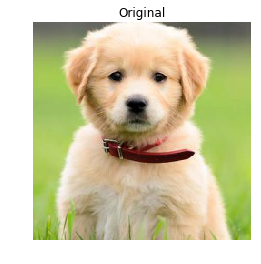

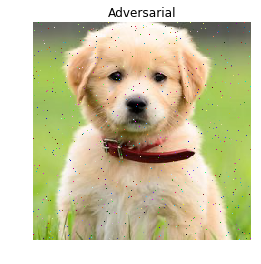

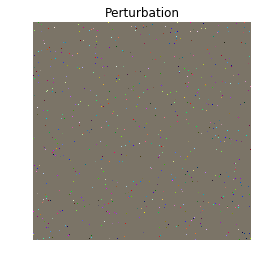

In [36]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title='Adversarial')
show_image(image_start.data - image_tensor, title='Perturbation')

Original:
goose 37.99434304237366 %
After Perturbation:
shower_curtain 92.11543202400208 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
bubble 95.31310796737671 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bicycle-built-for-two 69.30918097496033 %


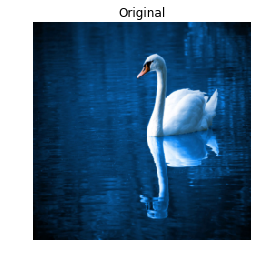

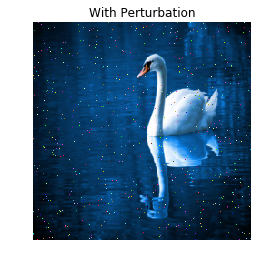

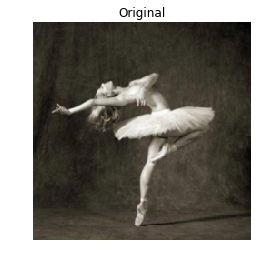

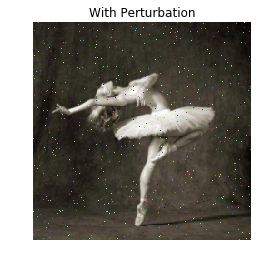

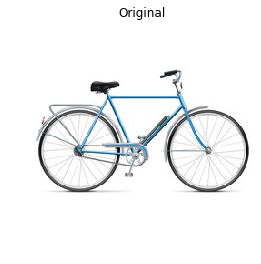

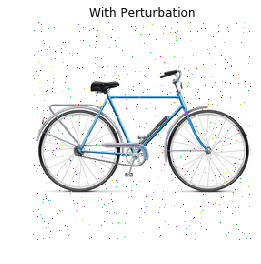

In [37]:
perturbation = image_start.data - image_tensor
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

### Approach above did not generalize, let's try minimizing expected loss across images

In [21]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting images
image_start_1 = load_image("./dog.jpg", (240,240))
image_start_2 = load_image("./dancing.jpg", (240,240))
image_start_3 = load_image("./bike.jpg", (240,240))

# These tensors stay fixed for reference points
image_tensor_1 = image_start_1.data
image_tensor_2 = image_start_2.data
image_tensor_3 = image_start_3.data


for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output_1 = cnn.forward(image_start_1)
    output_2 = cnn.forward(image_start_2)
    output_3 = cnn.forward(image_start_3)
    
    loss_value = loss(output_1, y_target) + loss(output_2, y_target) + loss(output_3, y_target) 
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad_1 = alpha * torch.sign(image_start_1.grad.data)
    grad_2 = alpha * torch.sign(image_start_2.grad.data)
    grad_3 = alpha * torch.sign(image_start_3.grad.data)
    
    # Only change pixels outside of randomized set
    grad_1 = zero_grad_outside_of_allowed_points(grad_1, n_points)
    grad_2 = zero_grad_outside_of_allowed_points(grad_2, n_points)
    grad_3 = zero_grad_outside_of_allowed_points(grad_3, n_points)
    
    # Need to clamp
    image_temp_1 = image_start_1.data - grad_1
    image_temp_2 = image_start_2.data - grad_2
    image_temp_3 = image_start_3.data - grad_3
    
    total_grad_1 = image_temp_1 - image_tensor_1
    total_grad_2 = image_temp_2 - image_tensor_2
    total_grad_3 = image_temp_3 - image_tensor_3
    
    
    total_grad_1 = torch.clamp(total_grad_1, -epsilon, epsilon)
    total_grad_2 = torch.clamp(total_grad_2, -epsilon, epsilon)
    total_grad_3 = torch.clamp(total_grad_3, -epsilon, epsilon)
    
    average_grad = (total_grad_1 + total_grad_2 + total_grad_3)/3
    
    image_start_1.data = image_tensor_1 + average_grad
    image_start_2.data = image_tensor_2 + average_grad
    image_start_3.data = image_tensor_3 + average_grad
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


bubble 42.820462584495544 %
balloon 33.21644067764282 %
spotlight 8.848898857831955 %
lampshade 7.026340067386627 %
fountain 1.8710950389504433 %
shower_curtain 1.4715345576405525 %
red_wine 0.8656547404825687 %
candle 0.7769461255520582 %
spider_web 0.617717020213604 %
groom 0.45767962001264095 %


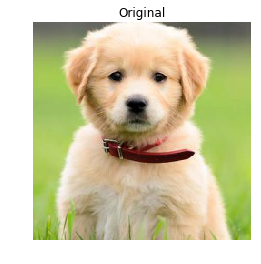

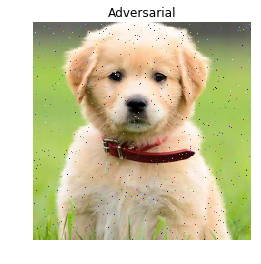

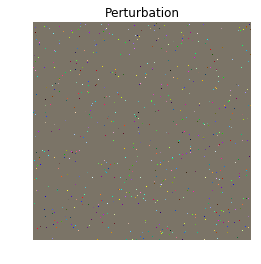

In [24]:
top_k(cnn(image_start_1))

show_image(image_tensor_1, title='Original')
show_image(image_start_1, title='Adversarial')
show_image(image_start_1.data - image_tensor, title='Perturbation')

Original:
goose 37.99434304237366 %
After Perturbation:
shower_curtain 98.71784448623657 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
bubble 53.878384828567505 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bubble 33.68956446647644 %


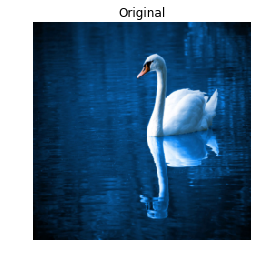

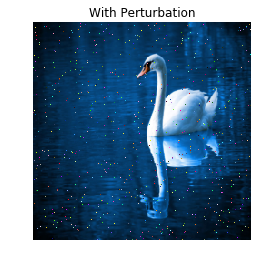

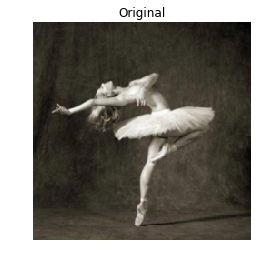

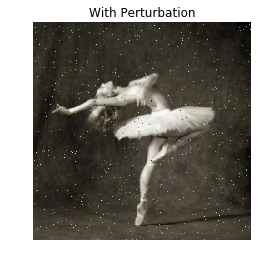

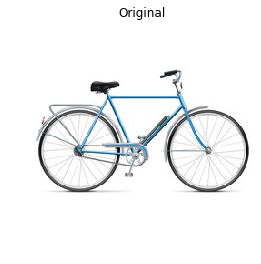

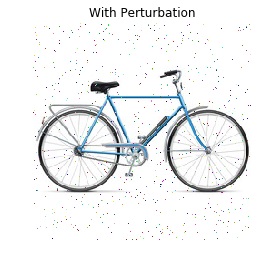

In [25]:
perturbation = image_start_1.data - image_tensor_1
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

Some pictures unseen during training:
Original:
screw 98.41756820678711 %
After Perturbation:
bubble 96.8731939792633 %
Original:
bagel 46.029168367385864 %
After Perturbation:
bubble 95.31418085098267 %


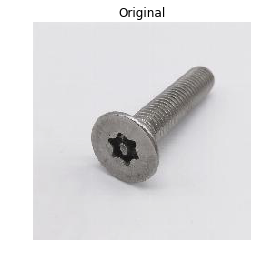

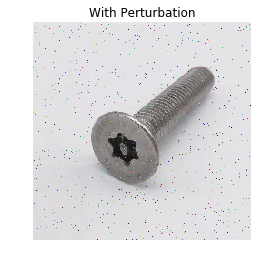

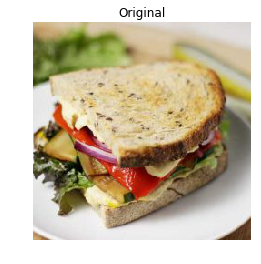

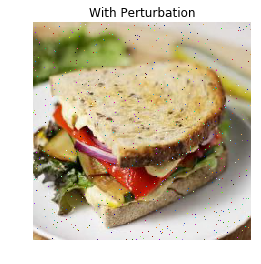

In [26]:
print('Some pictures unseen during training:')
image_plus_perturbation("./screw.jpg", perturbation)
image_plus_perturbation("./food.jpg", perturbation)

### Different Target Class

In [29]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([137]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting images
image_start_1 = load_image("./dog.jpg", (240,240))
image_start_2 = load_image("./dancing.jpg", (240,240))
image_start_3 = load_image("./bike.jpg", (240,240))

# These tensors stay fixed for reference points
image_tensor_1 = image_start_1.data
image_tensor_2 = image_start_2.data
image_tensor_3 = image_start_3.data


for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output_1 = cnn.forward(image_start_1)
    output_2 = cnn.forward(image_start_2)
    output_3 = cnn.forward(image_start_3)
    
    loss_value = loss(output_1, y_target) + loss(output_2, y_target) + loss(output_3, y_target) 
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad_1 = alpha * torch.sign(image_start_1.grad.data)
    grad_2 = alpha * torch.sign(image_start_2.grad.data)
    grad_3 = alpha * torch.sign(image_start_3.grad.data)
    
    # Only change pixels outside of randomized set
    grad_1 = zero_grad_outside_of_allowed_points(grad_1, n_points)
    grad_2 = zero_grad_outside_of_allowed_points(grad_2, n_points)
    grad_3 = zero_grad_outside_of_allowed_points(grad_3, n_points)
    
    # Need to clamp
    image_temp_1 = image_start_1.data - grad_1
    image_temp_2 = image_start_2.data - grad_2
    image_temp_3 = image_start_3.data - grad_3
    
    total_grad_1 = image_temp_1 - image_tensor_1
    total_grad_2 = image_temp_2 - image_tensor_2
    total_grad_3 = image_temp_3 - image_tensor_3
    
    
    total_grad_1 = torch.clamp(total_grad_1, -epsilon, epsilon)
    total_grad_2 = torch.clamp(total_grad_2, -epsilon, epsilon)
    total_grad_3 = torch.clamp(total_grad_3, -epsilon, epsilon)
    
    average_grad = (total_grad_1 + total_grad_2 + total_grad_3)/3
    
    image_start_1.data = image_tensor_1 + average_grad
    image_start_2.data = image_tensor_2 + average_grad
    image_start_3.data = image_tensor_3 + average_grad
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Original:
goose 37.99434304237366 %
After Perturbation:
pitcher 20.779310166835785 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
fountain 14.210930466651917 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bicycle-built-for-two 46.49848937988281 %
Some pictures unseen during training:
Original:
screw 98.41756820678711 %
After Perturbation:
screw 92.20165610313416 %
Original:
bagel 46.029168367385864 %
After Perturbation:
plate 37.1885746717453 %


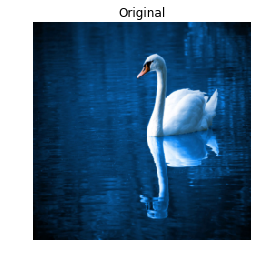

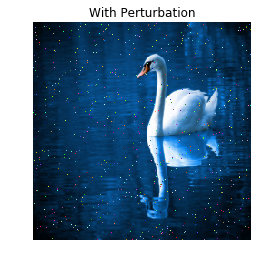

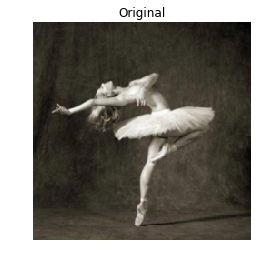

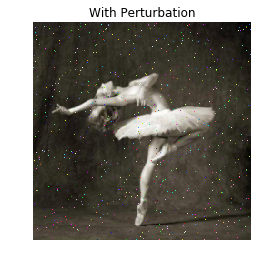

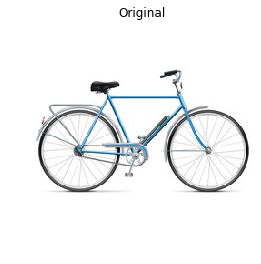

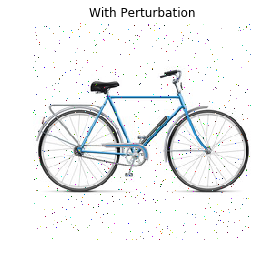

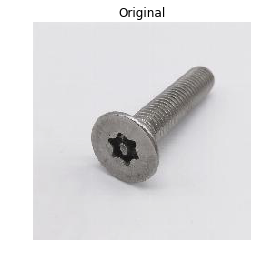

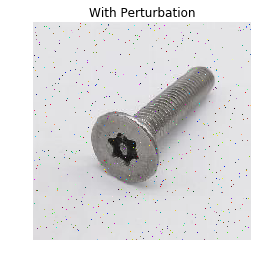

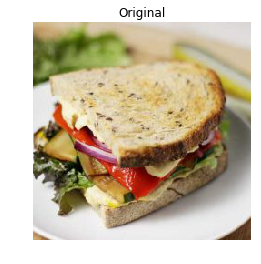

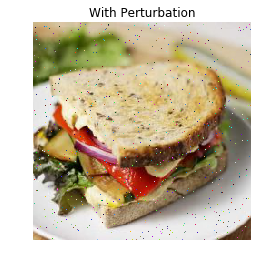

In [28]:
perturbation = image_start_1.data - image_tensor_1
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

print('Some pictures unseen during training:')
image_plus_perturbation("./screw.jpg", perturbation)
image_plus_perturbation("./food.jpg", perturbation)

### Let's see if we can get a uniform filter that pushes any class to a certain target class

In [66]:
def uniformize_grad(grad):
    total_pixels = 240*240
    mean_R = torch.sum(grad[:,0])/total_pixels
    mean_B = torch.sum(grad[:,1])/total_pixels
    mean_G = torch.sum(grad[:,2])/total_pixels
    
    grad_R = torch.FloatTensor(np.full((240, 240), mean_R))
    grad_B = torch.FloatTensor(np.full((240, 240), mean_B))
    grad_G = torch.FloatTensor(np.full((240, 240), mean_G))
    
    return torch.stack([grad_R, grad_B, grad_G], 0).unsqueeze(0)

In [93]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([924]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)
    grad = uniformize_grad(grad)
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [103]:
top_k(cnn(image_start))

# show_image(image_tensor, title='Original')
# show_image(image_start, title='Adversarial')
# show_image(image_start.data - image_tensor, title='Perturbation')

golden_retriever 44.67116594314575 %
red_wine 4.326852411031723 %
Brittany_spaniel 3.9988305419683456 %
Border_collie 3.026624582707882 %
clumber 2.806769870221615 %
soccer_ball 2.6008332148194313 %
kuvasz 2.4471336975693703 %
sunglasses 2.106505259871483 %
Labrador_retriever 2.078148163855076 %
tennis_ball 1.8782319501042366 %


In [92]:
torch.sum(grad[:,1] > 0.0001)

tensor(57600)

### Border with same perturbations along columns and rows

In [106]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # k pixels thick border
    k=1
    grad[:, :, :, :119] = 0
    grad[:, :, :, 122:] = 0
    
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


red_wine 99.99998211860657 %
wine_bottle 1.0085719281960337e-05 %
goblet 9.230144115690564e-06 %
syringe 3.3004612376430487e-07 %
lipstick 3.164556172663424e-07 %
pinwheel 1.8516593813799886e-07 %
bubble 1.1060833360332367e-07 %
flamingo 1.0108897052774068e-07 %
hip 8.725823952282497e-08 %
corkscrew 8.287310837573614e-08 %


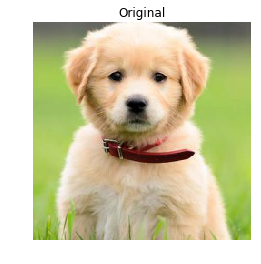

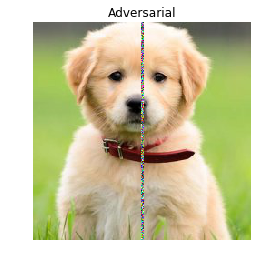

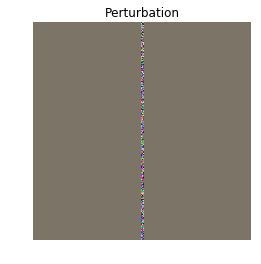

In [108]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title='Adversarial')
show_image(image_start.data - image_tensor, title='Perturbation')

pole 60.84728240966797 %
hook 14.546817541122437 %
parachute 5.421526730060577 %
flagpole 5.1726896315813065 %
reel 2.821451984345913 %
flamingo 1.9358405843377113 %
bubble 1.5582979656755924 %
ski 1.4061813242733479 %
red_wine 1.264320034533739 %
pinwheel 1.057965774089098 %


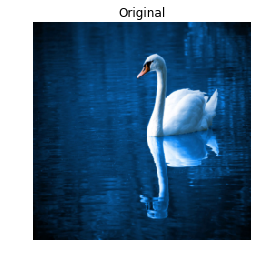

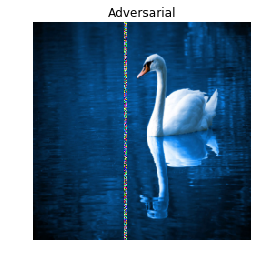

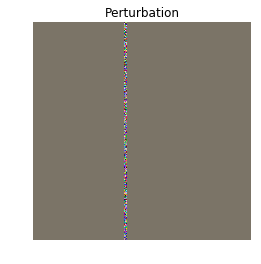

In [116]:
perturbation = image_start.data - image_tensor

image_tensor = load_image("./bird.jpg", (240,240)).data

img_shf = image_tensor.clone()
img_shf[:,:,:,100:103] += perturbation[:,:,:,119:122]

top_k(cnn(img_shf))

show_image(image_tensor, title='Original')
show_image(img_shf, title='Adversarial')
show_image(img_shf.data - image_tensor, title='Perturbation')